In [3]:
import pandas as pd
import os
from pathlib import Path
from PIL import Image

In [5]:
pkl_path = '../data/dataset.pkl'
images_dir = '../train'
output_labels_dir = '../bboxes'

os.makedirs(output_labels_dir, exist_ok=True)

df = pd.read_pickle(pkl_path)

display(df.sample(3, random_state=42))
print(f'\nКолонки: {df.columns.tolist()}')
print(f'Всего записей: {len(df)}')
print(f'Уникальных изображений: {df["file_name"].nunique()}')

,file_name,bbox,segmentation,category_id
1750,GX010294_MP4-0031_jpg.rf.v2bjFn7YdZWcgNFvQabS.jpg,"[525, 1109, 2960, 1051]","[1717, 1109, 1776, 1111, 3485, 2160, 525, 2160]",1
1583,GX010297_MP4-0821_jpg.rf.omnTe4SbZzg8iqemzOL9.jpg,"[0, 0, 1666, 1250]","[1651, 271, 1429, 0, 0, 0, 0, 1250, 1666, 360]",2
2741,GX010294_MP4-0071_jpg.rf.hwjr8hOKeo4JIhrI64hi.jpg,"[0, 161, 1733, 1310]","[1707, 880, 1035, 161, 0, 319, 0, 1471, 1733, ...",2



Колонки: ['file_name', 'bbox', 'segmentation', 'category_id']
Всего записей: 2962
Уникальных изображений: 994


In [6]:
image_col = 'file_name'
bbox_col = 'bbox'

grouped = df.groupby(image_col)

def get_image_size(image_name):
    img_path = Path(images_dir) / f'{Path(image_name).stem}.jpg'
    with Image.open(img_path) as img:
        return img.size

for image_name, group in grouped:
    img_size = get_image_size(image_name)
    width, height = img_size
    
    label_filename = Path(image_name).stem + '.txt'
    label_path = os.path.join(output_labels_dir, label_filename)
    
    with open(label_path, 'w') as f:
        for _, row in group.iterrows():
            bbox = row[bbox_col]
            x1, y1, x2, y2 = bbox
            
            if max(x1, y1, x2, y2) <= 1.0:
                w = x2 - x1
                h = y2 - y1
                x_center = x1 + w / 2
                y_center = y1 + h / 2
            else:
                x_center = (x1 + x2) / 2 / width
                y_center = (y1 + y2) / 2 / height
                w = (x2 - x1) / width
                h = (y2 - y1) / height
            
            f.write(f'0 {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n')
        
print(f'Разметка сохранена в: {output_labels_dir}')

Разметка сохранена в: ../bboxes


In [20]:
txt_files = list(Path(output_labels_dir).glob('*.txt'))[:3]

for txt_file in txt_files:
    print(f'\n{txt_file.name}:')

    with open(txt_file, 'r') as f:
        lines = f.readlines()
        
        for line in lines[:3]:
            print(f'\t{line.strip()}')



GX010294_MP4-0000_jpg.rf.e1vxkgH88EWFXDAaSAXc.txt:
	0 0.436068 0.500000 0.591406 0.014815
	0 0.500000 0.316898 -0.016667 0.633796
	0 0.248047 0.296296 0.496094 0.592593

GX010294_MP4-0001_jpg.rf.3BREHuE38vVF6YlmSChn.txt:
	0 0.500000 0.500000 0.772917 0.020370
	0 0.500000 0.338426 -0.023958 0.676852
	0 0.249609 0.342824 0.499219 0.685648

GX010294_MP4-0002_jpg.rf.gFHthWduKe2k3y3z5ekr.txt:
	0 0.500000 0.330324 -0.019792 0.660648
	0 0.249609 0.323611 0.499219 0.647222
	0 0.452734 0.500000 0.687240 0.014815


___
### Визуализация собранных bbox

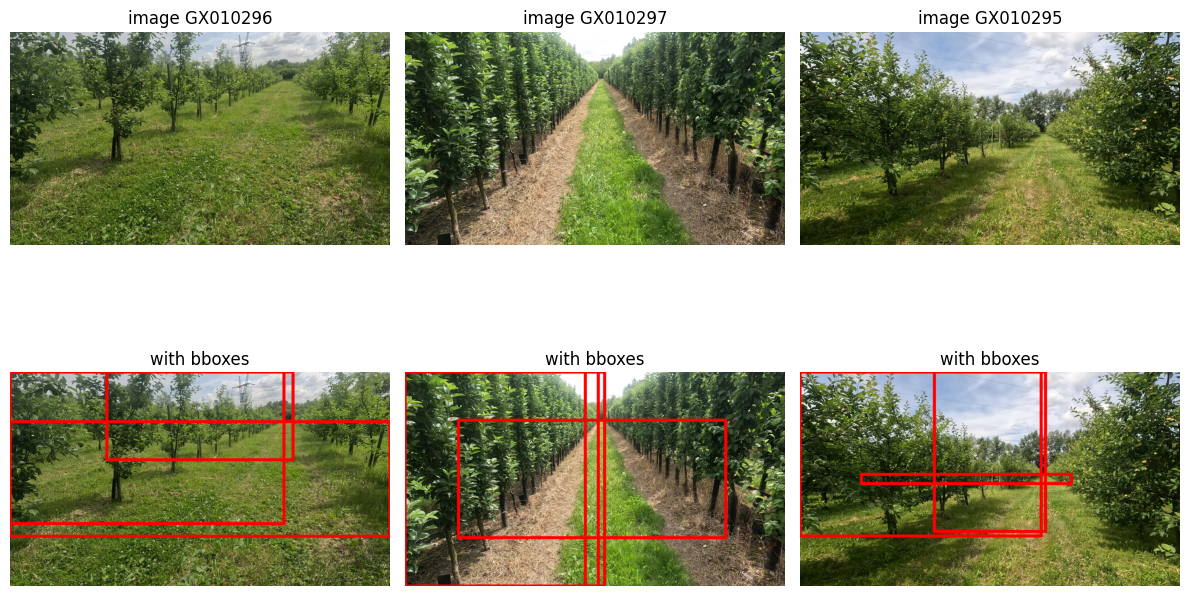

In [23]:
import random
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

def visualize_bboxes(num_examples=3):
    bbox_files = list(Path('../bboxes').glob('*.txt'))
    
    samples = random.sample(bbox_files, min(num_examples, len(bbox_files)))
    fig, axes = plt.subplots(2, len(samples), figsize=(4*len(samples), 8))
    
    for i, bbox_file in enumerate(samples):
        image_name = bbox_file.stem + '.jpg'
        img_path = f'../train/{image_name}'
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_with_boxes = img.copy()
        
        height, width = img.shape[:2]
        
        with open(bbox_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x_center, y_center, w, h = map(float, parts)
                    
                    x1 = int((x_center - w/2) * width)
                    y1 = int((y_center - h/2) * height)
                    x2 = int((x_center + w/2) * width)
                    y2 = int((y_center + h/2) * height)
                    
                    cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 30)
        
        axes[0, i].imshow(img)
        axes[0, i].set_title('image ' + image_name.split('_')[0])
        axes[0, i].axis('off')
        
        axes[1, i].imshow(img_with_boxes)
        axes[1, i].set_title('with bboxes')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_bboxes(3)